# “Análisis de la pobreza en el Perú por el nivel de ingresos e informalidad”

## 1. Introducción
El proyecto “Análisis de la pobreza en el Perú por el nivel de ingresos e informalidad” evalúa la pobreza en los hogares peruanos durante 2022 utilizando datos de la ENAHO del INEI. A través del análisis de más de 87,000 registros con Python, se identifican disparidades de ingresos, patrones de informalidad laboral y diferencias clave entre áreas urbanas y rurales. Este proyecto incluye limpieza de datos, creación de variables como "estado de pobreza", y visualizaciones que destacan la relación entre ingresos, informalidad y pobreza, ofreciendo insights para orientar políticas públicas.

📌 Los datos son descargados de la web oficial de ENAHO(Encuesta Nacional de hogares) - INEI (Instituto Nacional de Estadística e Informática) 2022

👉👉 https://www.datosabiertos.gob.pe/dataset/encuesta-nacional-de-hogares-enaho-2022-instituto-nacional-de-estad%C3%ADstica-e-inform%C3%A1tica-%E2%80%93

📌 Descargar el módulo ingresos y empleo (Enaho01a-2022-500) directo aquí:👇👇

✅ https://github.com/WLozanoH/Poverty-Peru/blob/main/Enaho01a-2022-500.zip

## 2. Entendimiento del proyecto
### Objetivo : 
*   Evaluar la pobreza en función de los ingresos y la informalidad, identificando disparidades económicas regionales.

### Hipótesis:
* A mayores ingresos, menor probabilidad de pobreza.

#### Variables clave:

Variables clave:

* Ingreso: ingreso_total (ingreso mensual total).
* Ocupación: ocupacion_principal, trabajo_ocup_principal, tipo_contrato, ocupacion_formalidad.
* Sociodemográficas: estrato, dominio, zonas, ubigeo.
* Temporalidad: mes.

### Método estadístico de análisis:
* Correlaciones, regresión logística, índice de Gini, percentiles y ANOVA.


In [123]:
#Importamos las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [124]:
#CARGAMOS SOLO LA DATA A ANALIZAR

df = pd.read_csv('Enaho01a-2022-500.csv', sep=',', usecols=['MES','NCONGLOME','VIVIENDA','HOGAR','CODPERSO','UBIGEO','DOMINIO','ESTRATO',
                                                            'P507','P510','P510A1',
                                                            'P511A','P524A1','OCUPINF'],
                 na_values= [' ', 999999])
df.head()


,MES,VIVIENDA,HOGAR,CODPERSO,UBIGEO,DOMINIO,ESTRATO,P507,P510,P510A1,P511A,P524A1,OCUPINF,NCONGLOME
0,2,3,11,1,10101,4,4,3.0,2.0,NaN,1.0,5000.0,2.0,7070
1,2,12,11,1,10101,4,4,4.0,6.0,2.0,7.0,800.0,1.0,7070
2,2,22,11,1,10101,4,4,3.0,2.0,NaN,1.0,1660.0,2.0,7070
3,2,22,11,2,10101,4,4,3.0,2.0,NaN,1.0,2300.0,2.0,7070
4,2,22,11,3,10101,4,4,2.0,NaN,3.0,NaN,NaN,1.0,7070


📌 Renombrando las variables del DataFrame para mejor manipulación de los datos

In [125]:
#Renombrando las variables
df.rename(columns={'P507':'ocupacion_principal',
                   'P510':'trabajo_ocup_principal',
                   'P510A1':'registro_sunat',
                   'P511A':'tipo_contrato',
                   'P524A1':'ingreso_total',
}, inplace=True)

#vivienda: Identificador de vivienda
#hogar: Identificador de hogar
#codperso: Identificador de persona

In [126]:
#Estandarizando los nombres de las columnas: todas a minúscula
df.columns = [col.lower() for col in df]

In [127]:
#Información general del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87661 entries, 0 to 87660
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mes                     87661 non-null  int64  
 1   vivienda                87661 non-null  int64  
 2   hogar                   87661 non-null  int64  
 3   codperso                87661 non-null  int64  
 4   ubigeo                  87661 non-null  int64  
 5   dominio                 87661 non-null  int64  
 6   estrato                 87661 non-null  int64  
 7   ocupacion_principal     65240 non-null  float64
 8   trabajo_ocup_principal  25050 non-null  float64
 9   registro_sunat          58720 non-null  float64
 10  tipo_contrato           37511 non-null  float64
 11  ingreso_total           25343 non-null  float64
 12  ocupinf                 61181 non-null  float64
 13  nconglome               87661 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 

## 3. Limpieza de datos
### 3.1. Estandarizando los valores de todas las variables

📌 Crear un diccionario para darle nombre a la subclasificación del Dominio Geográfico

In [128]:
#crear un diccionario para Dominio Geográfico, 
# variable = 'DOMINIO' para  almacenar los datos de cada región
dominio_geográfico = {
    1: 'Costa Norte',
    2: 'Costa Centro',
    3: 'Costa Sur',
    4: 'Sierra Norte',
    5: 'Sierra Centro',
    6: 'Sierra Sur',
    7: 'Selva',
    8: 'Lima Metropolitana'
}

#Reemplazar los valores numéricos por los nombres de dominio geográfico
df['dominio'] = df['dominio'].map(dominio_geográfico)


📌 Crear un diccionario para estrato la subclasificación de estrato geográfico - se determina las zonas urbanas y rurales


In [129]:
#Crear un diccionario para estrato geográfico
#Área de Empadronamiento Rural = AER
estrato_geografico = {
    
    1: "500,000 a más", 
    2: "100,000 a 499,999", 
    3: "50,000 a 99,999", 
    4: "20,000 a 49,999",
    5: "2,000 a 19,999", 
    6: "500 a 1,999", 
    7: "AER Compuesto",
    8: "AER Simple"
    
}

df['estrato'] = df['estrato'].map(estrato_geografico)

#### Análisis de ocupación principal

In [130]:
# Análisis de 'ocupacion_principal'

ocupaciones = {
    
    1.0:'empleador',
    2.0:'independiente',
    3.0: 'empleado',
    4.0: 'obrero',
    5.0: 'no remunerado',
    6.0: 'trab. hogar',
    7.0: 'otro'
}

#reemplazamos los valores en la variable 'ocupacion_principal'
df['ocupacion_principal'] = df['ocupacion_principal'].map(ocupaciones)

#revisamos valores en:
print(df['ocupacion_principal'].info())
print(df['ocupacion_principal'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: ocupacion_principal
Non-Null Count  Dtype 
--------------  ----- 
65240 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
ocupacion_principal
independiente    25254
NaN              22421
obrero           12697
empleado         12042
no remunerado    11628
empleador         2208
trab. hogar       1100
otro               311
Name: count, dtype: int64


In [131]:
#Análisis de variable 'trabajo_ocup_principal':

trabajos = {
    
    1.0:'Emp.pública',
    2.0:'Emp.pública',
    3.0:'Emp.pública',
    4.0:'emp.privada',
    5.0:'Emp.privada',
    6.0:'otra'

}

#reemplazamos los valores en la variable 'trabajo_ocup_principal'
df['trabajo_ocup_principal'] = df['trabajo_ocup_principal'].map(trabajos)

#revisamos valores en:
print(df['trabajo_ocup_principal'].info())

print(df['trabajo_ocup_principal'].value_counts(dropna=False))


<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: trabajo_ocup_principal
Non-Null Count  Dtype 
--------------  ----- 
25050 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
trabajo_ocup_principal
NaN            62611
otra           19223
Emp.pública     5420
Emp.privada      407
Name: count, dtype: int64


In [132]:
#variable 'registros_sunat'

#crear un diccionario para mapear datos de registro_sunat
registros_sunat = {
    
    1.0:'persona jurídica',
    2.0:'persona natural',
    3.0: 'no está registrado',
}

#reemplazamos los valores en la variable 'registro_sunat'
df['registro_sunat'] = df['registro_sunat'].map(registros_sunat)

df['registro_sunat'] = df['registro_sunat'].replace({'persona natural':'formal', 'persona jurídica':'formal', 'no está registrado':'informal'})
print(df['registro_sunat'].info())

print(df['registro_sunat'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: registro_sunat
Non-Null Count  Dtype 
--------------  ----- 
58720 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
registro_sunat
informal    43786
NaN         28941
formal      14934
Name: count, dtype: int64


In [133]:
#Creamos una variable 'informalidad' a partir de las variables 'ocupinf' y 'registros_sunat'
df['ocupinf'] = df['ocupinf'].replace({1.0: 'informal', 2.0: 'formal'})

print(df['ocupinf'].info())
print(df['ocupinf'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: ocupinf
Non-Null Count  Dtype 
--------------  ----- 
61181 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
ocupinf
informal    48339
NaN         26480
formal      12842
Name: count, dtype: int64


In [134]:
#Crear una sola variable para medir la informalidad
df['ocupacion_formalidad'] = df['registro_sunat'].fillna(df['ocupinf'])

print(df['ocupacion_formalidad'].info())

print(df['ocupacion_formalidad'].value_counts(dropna=False))

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: ocupacion_formalidad
Non-Null Count  Dtype 
--------------  ----- 
65240 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
ocupacion_formalidad
informal    45990
NaN         22421
formal      19250
Name: count, dtype: int64


In [135]:
#Eliminamos las variables 'ocupinf' y 'registro_sunat'
df.drop(columns=['ocupinf','registro_sunat'], inplace=True)

In [136]:
# Análisis de la variable 'tipo_contrato' = el tipo de contrato que tiene la persona donde está laborando

#mapeando valores para 'tipo_contrato'
tipos_contratos = {
    
    1:'permanente',
    2:'temporal',
    3: 'temporal',
    4: 'prácticas',
    5: 'servicios',
    6: 'Adm.pública',
    7: 'servicios',
}

#reemplazamos los valores en la variable 'tipo_contrato'
df['tipo_contrato'] = df['tipo_contrato'].map(tipos_contratos)

#revisamos valores en:
print(df['tipo_contrato'].info())
print(df['tipo_contrato'].value_counts())

<class 'pandas.core.series.Series'>
RangeIndex: 87661 entries, 0 to 87660
Series name: tipo_contrato
Non-Null Count  Dtype 
--------------  ----- 
37510 non-null  object
dtypes: object(1)
memory usage: 685.0+ KB
None
tipo_contrato
servicios      26755
temporal        6171
permanente      3753
Adm.pública      689
prácticas        142
Name: count, dtype: int64


📌 Analizamos la variable "ESTRATO" para clasificar la muestra en URBANO y RURAL

    'AER' = Área de empadronamiento RURAL

In [137]:
#Creando la variable 'ZONAS' para identificar la muestra urbana y rural
df['zonas'] = df['estrato']
#clasificamos la variable 'urbana' y 'rural' usando lambda
df['zonas'] = df['zonas'].apply(lambda x:'rural' if x == 'AER Simple' or  x == 'AER Compuesto' else 'urbano')

In [138]:
# Porcentaje de la muetra total para la zona urbana y rural
print((df['zonas'].value_counts(normalize=True) *100).round(2))

zonas
urbano    72.38
rural     27.62
Name: proportion, dtype: float64


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87661 entries, 0 to 87660
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mes                     87661 non-null  int64  
 1   vivienda                87661 non-null  int64  
 2   hogar                   87661 non-null  int64  
 3   codperso                87661 non-null  int64  
 4   ubigeo                  87661 non-null  int64  
 5   dominio                 87661 non-null  object 
 6   estrato                 87661 non-null  object 
 7   ocupacion_principal     65240 non-null  object 
 8   trabajo_ocup_principal  25050 non-null  object 
 9   tipo_contrato           37510 non-null  object 
 10  ingreso_total           25343 non-null  float64
 11  nconglome               87661 non-null  int64  
 12  ocupacion_formalidad    65240 non-null  object 
 13  zonas                   87661 non-null  object 
dtypes: float64(1), int64(6), object(7)
mem

### 3.2. Completando valores nulos

In [140]:
#verificando valores nulos
total_valores_nulos = df.isnull().sum()
porcentaje_valores_nulos = ((total_valores_nulos/len(df)) *100).round(2)

#creamos un dataframe para mostrar solo resultados nulos
resultado_nulos = pd.DataFrame({'total_nulos':total_valores_nulos,'Porcentaje Nulos(%)':porcentaje_valores_nulos})
print(resultado_nulos)

                        total_nulos  Porcentaje Nulos(%)
mes                               0                 0.00
vivienda                          0                 0.00
hogar                             0                 0.00
codperso                          0                 0.00
ubigeo                            0                 0.00
dominio                           0                 0.00
estrato                           0                 0.00
ocupacion_principal           22421                25.58
trabajo_ocup_principal        62611                71.42
tipo_contrato                 50151                57.21
ingreso_total                 62318                71.09
nconglome                         0                 0.00
ocupacion_formalidad          22421                25.58
zonas                             0                 0.00


#### Ninguna variable tiene un porcentaje de valores Nan menores o iguales a 5%, así que pasamos a imputarlos con medidas estadísticas

*   Para variables categóricas, imputamos el valor más común (moda)
*   Para variables numéricas, imputamos la mediana

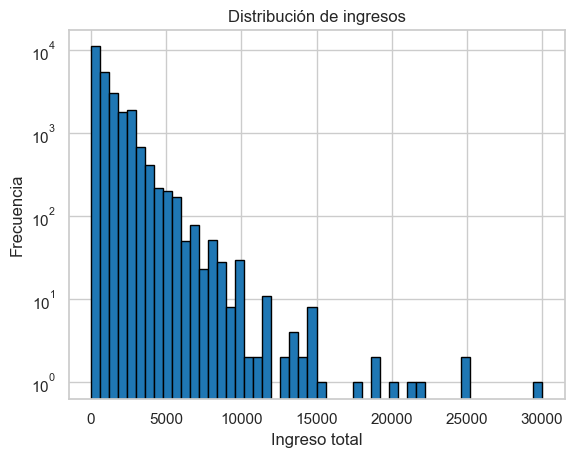

In [141]:
df['ingreso_total'].plot(kind='hist', bins=50, edgecolor='black', log=True)
plt.title('Distribución de ingresos')
plt.xlabel('Ingreso total')
plt.ylabel('Frecuencia')
plt.show()

In [142]:
#Analizando la variable 'ingreso_total'
df['ingreso_total'].describe()

count    25343.000000
mean      1240.874009
std       1441.637968
min          1.000000
25%        280.000000
50%        900.000000
75%       1700.000000
max      30000.000000
Name: ingreso_total, dtype: float64

Completamos valores Nan en la variable 'ingreso_total' agrupando por conglomerado y usando la mediana, dado que es una técnica estadística más precisa cuando hay alta dispersión de valores, en este caso muy extremos, siendo el mínimo 1 y el máximo 30000.


#### Agrupamos por 'nconglome', que agrupa subconjuntos de las localidades donde se realizaron las encuestas a nivel nacional.

In [143]:
#Imputar variables numéricas con la mediana por 'nconglome': usamos la mediana debido al sesgo en los datos.

# Paso 1: Agrupar por 'nconglome' obtener la mediana y convertirlo a diccionario
ingreso_total_dict = df.groupby(['nconglome'])['ingreso_total'].median().to_dict()

# Paso 2: Completar los valores Nan en ingreso total con la mediana usando el diccionario creado.
df['ingreso_total'] = df['ingreso_total'].fillna(df['nconglome'].map(ingreso_total_dict))

print(df.isna().sum())

mes                           0
vivienda                      0
hogar                         0
codperso                      0
ubigeo                        0
dominio                       0
estrato                       0
ocupacion_principal       22421
trabajo_ocup_principal    62611
tipo_contrato             50151
ingreso_total              3362
nconglome                     0
ocupacion_formalidad      22421
zonas                         0
dtype: int64


In [144]:
# Imputar variables categóricas con la moda por 'nconglome'

#Listar variables categóricas que faltan 
categorical_vars = ['ocupacion_principal','trabajo_ocup_principal','tipo_contrato','ocupacion_formalidad']

for var in categorical_vars:
    #Paso1: Agrupar por 'nconglome' y obtener la moda
    mode_dict = df.groupby('nconglome')[var].agg(lambda x: x.mode()[0] if not x.mode().empty else None).to_dict()
    
    #Paso2: Imputar la moda en los valores faltantes
    df[var] = df[var].fillna(df['nconglome'].map(mode_dict))
    
#Verificar los valores faltantes
print(df.isna().sum())

mes                          0
vivienda                     0
hogar                        0
codperso                     0
ubigeo                       0
dominio                      0
estrato                      0
ocupacion_principal          2
trabajo_ocup_principal    3189
tipo_contrato               96
ingreso_total             3362
nconglome                    0
ocupacion_formalidad         2
zonas                        0
dtype: int64


In [145]:
#Los valores Nan restantes procedemos a eliminarlos
print(f'# filas antes de eliminar los Nan restantes: {df.shape[0]}')
df.dropna(inplace=True)
print(f'# filas después de eliminar los Nan restantes: {df.shape[0]}')

# filas antes de eliminar los Nan restantes: 87661
# filas después de eliminar los Nan restantes: 84055


### 3.2. Manejo de valores duplicados

In [146]:
#Verificar duplicados exactos en todo el DataFrame
duplicados_exactos = df[df.duplicated()].shape[0]
print(f'La cantidad de duplicados exactos en el DataFrame es: {duplicados_exactos}')

#Eliminado valores duplicados
print(f'# de filas antes de eliminar duplicados: {df.shape[0]}')
df.drop_duplicates(inplace=True)
print(f'# de filas después de eliminar duplicados: {df.shape[0]}')

La cantidad de duplicados exactos en el DataFrame es: 1
# de filas antes de eliminar duplicados: 84055
# de filas después de eliminar duplicados: 84054


### 3.4. Eliminando valores atípicos

#### Agrupar por nconglomerado y eliminar valores atípicos utilizando el IQR(Rango intercuartil)

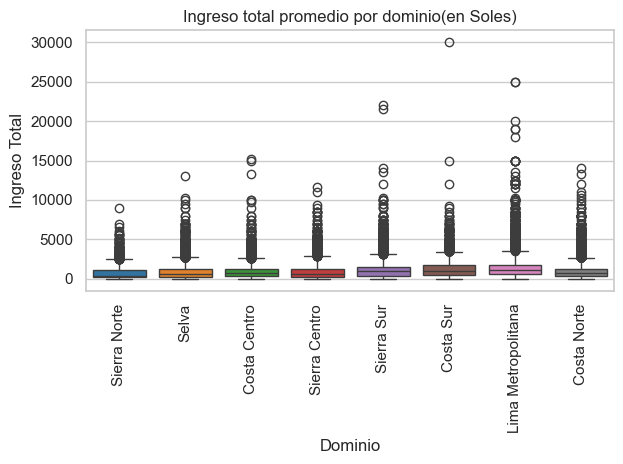

count    84054.000000
mean      1050.765972
std       1080.656330
min          1.000000
25%        300.000000
50%        800.000000
75%       1400.000000
max      30000.000000
Name: ingreso_total, dtype: float64


In [147]:
#Gráfico de los ingresos promedio mensual por dominio antes de eliminar outliers
sns.boxplot(data=df, x='dominio', y='ingreso_total', hue = 'dominio')

#Título y ejes
plt.title('Ingreso total promedio por dominio(en Soles)')
plt.xlabel('Dominio')
plt.ylabel('Ingreso Total')
plt.xticks(rotation = 90)

#Ajustamos el gráfico y lo mostramos
plt.tight_layout()
plt.show()

print(df['ingreso_total'].describe())

In [148]:
# Calcular IQR por nconglomerado
def eliminar_outliers(grupo):
    Q1 = grupo['ingreso_total'].quantile(0.25)
    Q3 = grupo['ingreso_total'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return grupo[(grupo['ingreso_total'] >= lower_bound) & (grupo['ingreso_total'] <= upper_bound)]

# Aplicar a cada conglomerado
df_sin_outliers = df.groupby('nconglome').apply(eliminar_outliers).reset_index(drop=True)

print(f'Numero de filas con outliers: {df.shape[0]}')
print(f'Numero de filas sin outliers: {df_sin_outliers.shape[0]}')

Numero de filas con outliers: 84054
Numero de filas sin outliers: 63829


Hay 96 valores mayores a 6'000 soles.


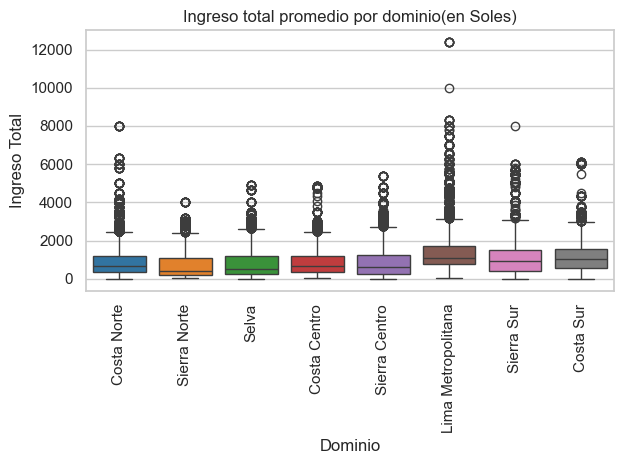

count    63829.000000
mean       971.923138
std        874.749614
min          5.000000
25%        300.000000
50%        790.000000
75%       1308.000000
max      12380.000000
Name: ingreso_total, dtype: float64


In [149]:
#Cantidad de datos mayores a 6'000 soles
tamaño_valores_mas_10000 = df_sin_outliers[(df_sin_outliers['ingreso_total'] > 6000)].shape[0]
print(f"Hay {tamaño_valores_mas_10000} valores mayores a 6'000 soles.")

#Gráfico de los ingresos promedio mensual por dominio después de eliminar outliers
sns.boxplot(data=df_sin_outliers, x='dominio', y='ingreso_total', hue = 'dominio')

#Título y ejes
plt.title('Ingreso total promedio por dominio(en Soles)')
plt.xlabel('Dominio')
plt.ylabel('Ingreso Total')
plt.xticks(rotation = 90)

#Ajustamos el gráfico y lo mostramos
plt.tight_layout()
plt.show()

print(df_sin_outliers['ingreso_total'].describe())

Hemos eliminado valores atípicos usando el rango intercuartil(IQR), ahora observamos que el valor máximo en el ingreso total a disminuído a 12'380, y además solo hay 5 personas con ingresos mayores a 10'000 soles.

#### Resumen:  Limpieza y preparación de datos

* Pasos realizados:

    * 1. Estandarización: Renombrar columnas y crear diccionarios para interpretar variables categóricas.
    * 2. Manejo de valores nulos:
        * Imputación con mediana para variables numéricas y moda para categóricas, agrupando por nconglome.
    * 3. Eliminación de duplicados: Identificados y removidos duplicados exactos.
    * 4. Tratamiento de valores atípicos: Eliminados usando el rango intercuartil (IQR), lo que redujo valores extremos en ingreso_total.

Resultados:

Los datos finales cuentan con 63,829 registros, representando una muestra limpia y lista para el análisis.

### 4. Análisis exploratorio de datos (EDA)

#### 4.1. Análisis de la distribución 

#### 4.1.1 Distribución de variables numéricas: 'ingreso_total'

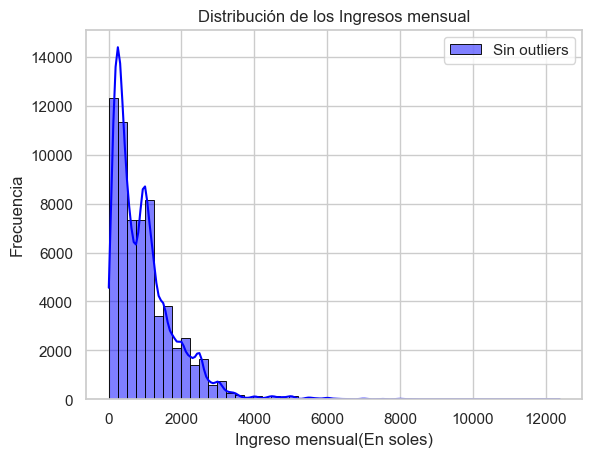

In [150]:
sns.histplot(data=df_sin_outliers, x='ingreso_total', bins=50, edgecolor='black',
             kde=True, color='blue', label='Sin outliers')

plt.title('Distribución de los Ingresos mensual')
plt.xlabel('Ingreso mensual(En soles)')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

In [151]:
df_sin_outliers['ingreso_total'].describe()

count    63829.000000
mean       971.923138
std        874.749614
min          5.000000
25%        300.000000
50%        790.000000
75%       1308.000000
max      12380.000000
Name: ingreso_total, dtype: float64

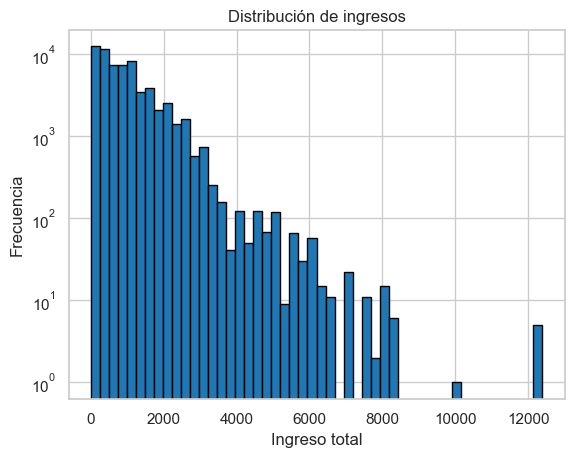

In [152]:
df_sin_outliers['ingreso_total'].plot(kind='hist', bins=50, edgecolor='black', log=True)
plt.title('Distribución de ingresos')
plt.xlabel('Ingreso total')
plt.ylabel('Frecuencia')
plt.show()

Observamos asímetría positiva con sesgo hacia la derecha(ingresos altos), dado que la mayor parte de los ingresos(75%) están concentrados en valores más bajos(inferiores a 2'000 soles).

Hay un pequeño grupo de personas con ingresos significativamente mayores en comparación con la mayoría, lo que indica una distribución desigualdad de los ingresos. 

La mayor densidad para todos los dominios ocurre en valores bajos de ingresos (menores a 2000 soles), reflejando que la mayoría de la población tiene ingresos moderados o bajos.

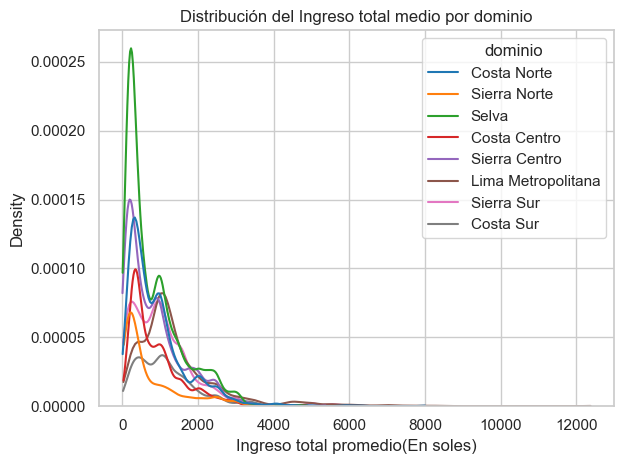

In [153]:
sns.kdeplot(data=df_sin_outliers, x='ingreso_total', hue='dominio',
            cut=0)

#Título y etiquetas
plt.title('Distribución del Ingreso total medio por dominio')
plt.xlabel('Ingreso total promedio(En soles)')

#Ajustar y mostrar gráfico
plt.tight_layout()
plt.show()

* Lima Metropolitana: tiene la cola más extendida hacia la derecha, lo que indica que una proporción de personas con ingresos altos en comparación con los otros dominios.

* Selva: presenta el pico más alto y estrecho en densidad de ingresos bajos, lo que indica que los ingresos en esta región son más homogéneos y concentrados en niveles bajos.

* Costa Norte y Sierra Norte: estas distribuciones son más similares, con un pico en ingresos bajos y una cola moderada hacia ingresos medios.

*  Sierra(centro y sur) y costa centro: estas regiones muestran un comportamiento intermedio, con una menor densidad de ingresos altos que Lima, pero hay más dispersión que en la selva

#### 4.1.2. Distribución de variables categóricas: 'ingreso_total'

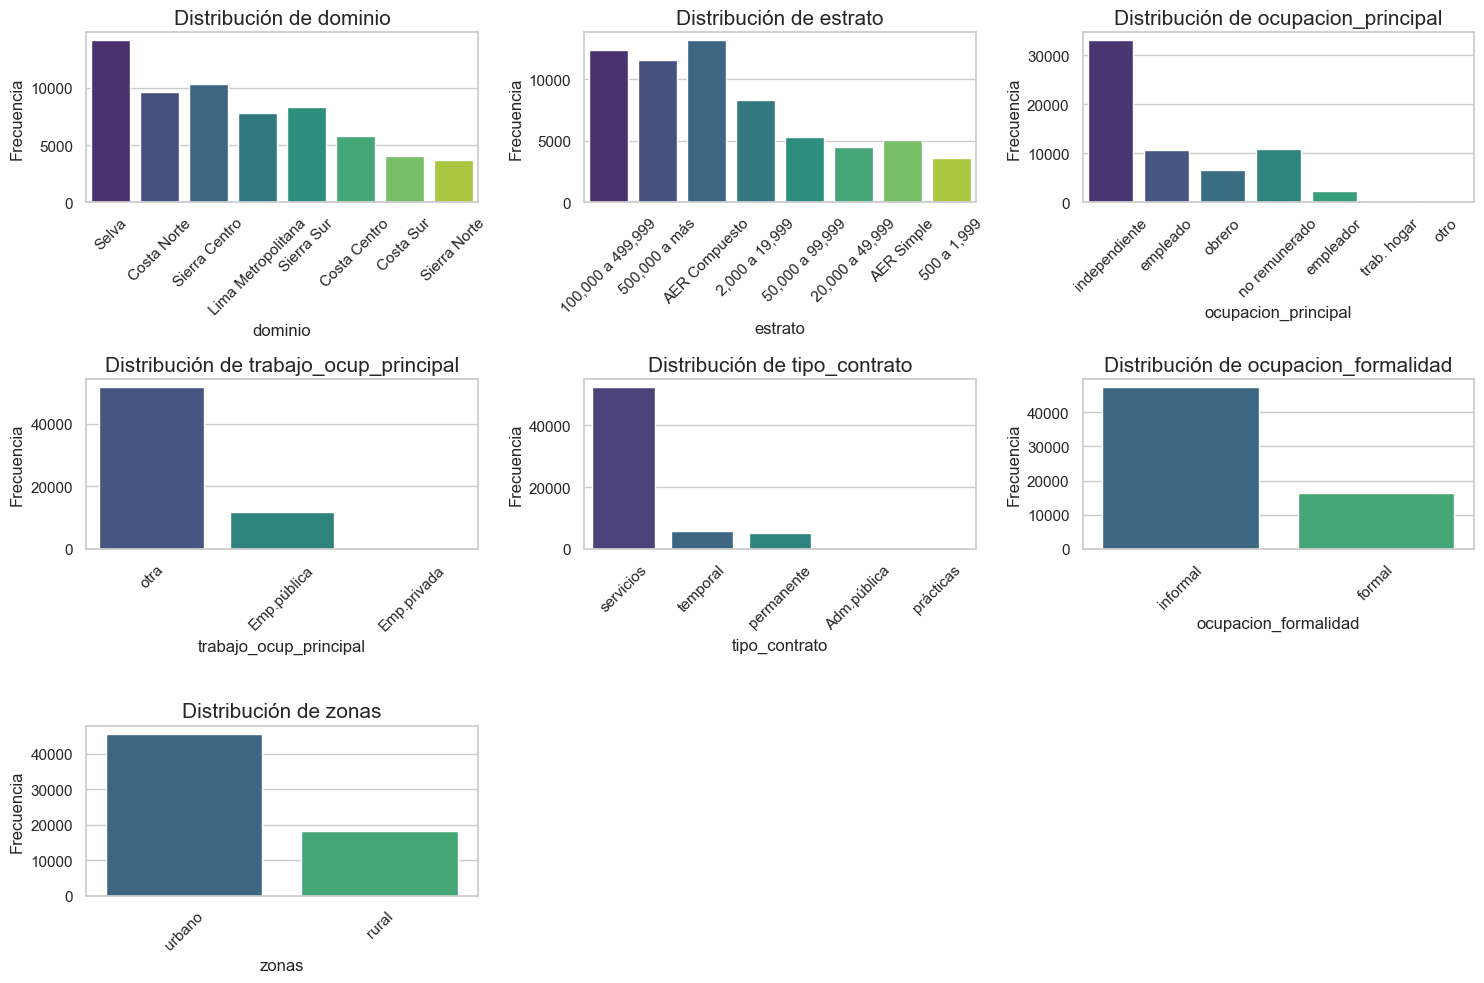

In [154]:
#Seleccionar las variables categóricas a analizar
categorical_vars = df_sin_outliers.select_dtypes('object')

#Definir fondo con líneas
sns.set_style('whitegrid') #fondo con líneas

# Definimos el número de filas y columnas de acuerdo con el número de variables categóricas
num_vars = len(categorical_vars.columns)
num_rows = (num_vars // 2) + (num_vars % 2)  # Dos gráficos por fila

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Crear una cuadrícula
fig.subplots_adjust(hspace=0.5) #Espacio entre gráficos(filas)
axes = axes.flatten()  # # Aplanar los ejes para iterar fácilmente
#crear gráficos
for i, var in enumerate(categorical_vars):
    sns.countplot(data=df_sin_outliers, x=var, ax=axes[i], palette='viridis', order=df[var].value_counts().index)
    
    #Establecer título y etiquetas
    axes[i].set_title(f'Distribución de {var}', fontsize = 15)
    axes[i].set_xlabel(var, fontsize = 12)
    axes[i].set_ylabel('Frecuencia', fontsize = 12)
    axes[i].tick_params(axis ='x', rotation = 45)   # Rotar etiquetas para mejor visualización

#Eliminar subplots vacíos:
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
#Ajustar diseño de gráfico y mostrar
plt.tight_layout()
plt.show()

Observaciones

#### Crear la variable 'formalidad' usando la 'ocupacion_formalidad' y darle formato entero

* Si es formal = 0
* Si es informal = 1

In [155]:
#Copiar la variable 'ocupacion_formalidad' en 'formalidad' usando copy()
df_sin_outliers['es_formal'] = df_sin_outliers['ocupacion_formalidad'].copy()
df_sin_outliers['es_formal'] = df_sin_outliers['es_formal'].replace({'informal': 1, 'formal': 0})
df_sin_outliers['es_formal'] = df_sin_outliers['es_formal'].astype(int)

#Verificar ambas variables pobreza
print(df_sin_outliers[['ocupacion_formalidad','es_formal']].info())
print(df_sin_outliers[['ocupacion_formalidad','es_formal']].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63829 entries, 0 to 63828
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ocupacion_formalidad  63829 non-null  object
 1   es_formal             63829 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 748.1+ KB
None
ocupacion_formalidad  es_formal
informal              1            47338
formal                0            16491
Name: count, dtype: int64


#### Crear la variable 'estado_pobreza', para analizar la pobreza Monetaria en 2022 , usando la línea de pobreza
* Umbral de pobreza urbano: 415 soles
* Umbral de pobreza rural: 290 soles
    * Si es pobre: 1
    * Si no es pobre: 0

no pobre: 70.61%
pobre: 29.39%


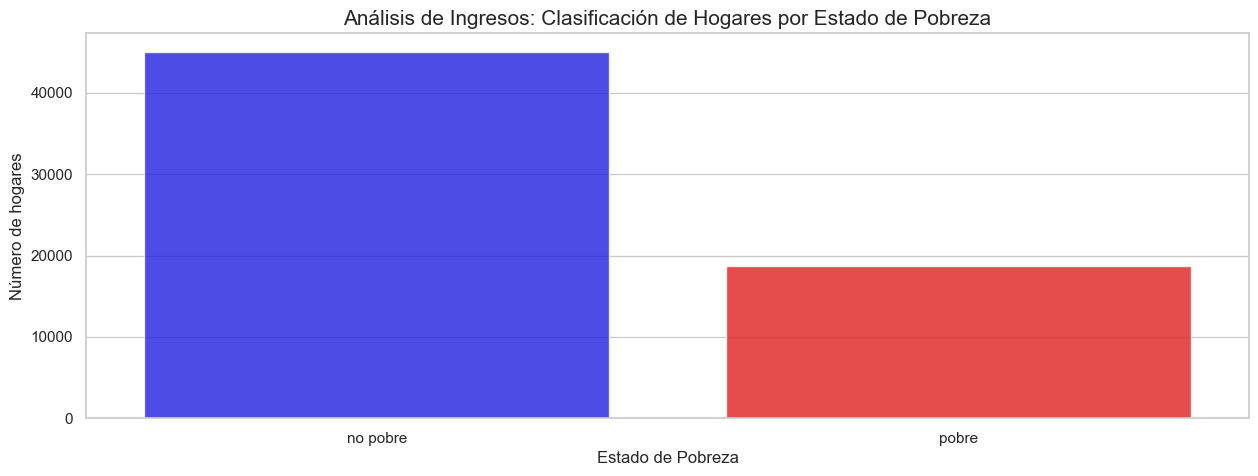

In [156]:
#Crear la vari
# Paso 1: Definir la línea de pobreza
lineas_pobreza = {
    'urbano': {'pobreza': 415},  # Solo una línea para "pobre"
    'rural': {'pobreza': 290}    # Solo una línea para "pobre"
}

# Paso 2: Crear una función para clasificar a los hogares
def clasificar_hogares(row):
    if row['zonas'] == 'urbano':
        linea_pobreza = lineas_pobreza['urbano']['pobreza']
    else:
        linea_pobreza = lineas_pobreza['rural']['pobreza']
    
    # Clasificación: Si el ingreso total es menor que la línea de pobreza, se clasifica como 'Pobre'.
    if row['ingreso_total'] < linea_pobreza:
        return 'pobre'
    else:
        return 'no pobre'

# Paso 3: Aplicar la función
df_sin_outliers['estado_pobreza'] = df_sin_outliers.apply(clasificar_hogares, axis=1)

# Paso 4: Imprimir resumen de la cantidad total de pobreza y porcentaje
pobreza_porcentaje = (df_sin_outliers['estado_pobreza'].value_counts(normalize=True) * 100).round(2)
#iteramos en los resultados
for categoria, porcentaje in pobreza_porcentaje.items():
    print(f"{categoria}: {porcentaje}%")

# Paso 5: Graficar la variable estado pobreza
set_color = ['blue', 'red']
plt.figure(figsize=(15,5))
sns.countplot(x='estado_pobreza', data=df_sin_outliers, palette= set_color, alpha = 0.8)
plt.title("Análisis de Ingresos: Clasificación de Hogares por Estado de Pobreza", fontsize=15)
plt.xlabel('Estado de Pobreza', fontsize=12)
plt.ylabel('Número de hogares', fontsize=12)

# Mostrar la gráfica
plt.show()

##### Crear una variable numérica de pobreza llamada 'es_pobre'
* pobre:1 
* no pobre: 0

In [157]:
#crear una variable numérica de pobreza llamada 'es_pobre', pobre:1 - no pobre: 0
df_sin_outliers['es_pobre'] = df_sin_outliers['estado_pobreza']
df_sin_outliers['es_pobre'] = df_sin_outliers['es_pobre'].replace({'pobre': 1, 'no pobre': 0})
df_sin_outliers['es_pobre'] = df_sin_outliers['es_pobre'].astype(int)

#Mostrar las variables pobreza
print(f'porcentaje de pobreza: {(df_sin_outliers[['estado_pobreza', 'es_pobre']].value_counts(normalize=True)).round(2)*100}')

porcentaje de pobreza: estado_pobreza  es_pobre
no pobre        0           71.0
pobre           1           29.0
Name: proportion, dtype: float64


#### 4.2. Análisis de relaciones entre variables

* Correlación entre variables numéricas

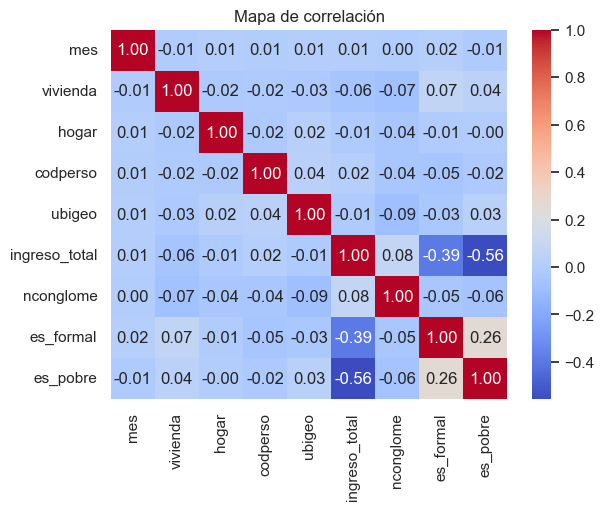

In [158]:
#Seleccionando las variables numericas
var_numericas = df_sin_outliers.select_dtypes('number')
corr = var_numericas.corr()

sns.heatmap(corr, annot=True, cmap = 'coolwarm', fmt='.2f')

plt.title('Mapa de correlación') #Título
plt.show() #Mostrar el gráfico

* Ingreso total (ingreso_total) y pobreza (es_pobre)

    Se observa correlación negativa entre 'ingreso_total' y 'es_pobre' (-0.56) es fuerte, lo que significa que a medida que aumenta el ingreso, disminuye la probabilidad de ser pobre. Esto respalda la teoría de que el ingreso es un factor clave en la pobreza.

* Formalidad de la ocupación (es_formal) y pobreza (es_pobre):

    La correlación entre 'es_formal' y 'es_pobre' es positiva(0.26), lo que sugiere que las personas con ocupaciones formales tienen una menor probabilidad de ser pobres. Sin embargo la correlación es moderada, lo que indica que, aunque la formalidad tienen un efecto positivo en la reducción de la pobreza, no es un factor exclusivo.

* Ingreso total (ingreso_total) y formalidad (es_formal): 

    La correlación negativa (-0.39) entre 'ingreso_total' y 'es_formal', sugiere que a menor ingreso hay más personas en trabajos informales. Esto indica que los trabajos informales están muy correlacionados con bajos niveles de ingreso.

##### Resumen del mapa de calor

La pobreza en la muestra está fuertemente influenciada por el nivel de ingreso, con una correlación negativa entre los ingresos y la pobreza. Además, la informalidad del trabajo también está relacionada con un nivel de ingresos más bajo, lo que, a su vez, aumenta la probabilidad de ser pobre. La ocupación formal, aunque presenta una correlación moderada con la pobreza, puede actuar como un factor protector frente a la pobreza, aunque no es suficiente por sí sola para erradicarla.

* Relaciones entre variables categóricas y numéricas:

Text(0.5, 1.03, 'Análisis de la tasa de pobreza por tipo de empleo e Ingresos promedio')

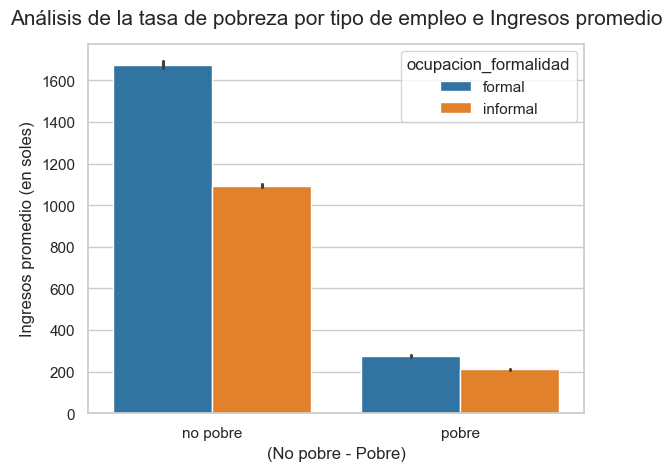

In [159]:
#Definimos el fonde de trabajo con líneas

sns.set_style('whitegrid')

#Aplicamos un gráfico de barras
g = sns.barplot( x='estado_pobreza', y='ingreso_total',
                hue = 'ocupacion_formalidad', 
                data = df_sin_outliers)
g.set(xlabel = '(No pobre - Pobre)',
        ylabel = 'Ingresos promedio (en soles)')
g.set_title('Análisis de la tasa de pobreza por tipo de empleo e Ingresos promedio', 
          fontsize = 15, y = 1.03)

Este gráfico refuerza la idea que la pobreza está estrechamente relacionada con los ingresos. Además muestra que los trabajos formales generalmente brindan un nivel de ingresos más alto que los trabajos informales, lo que resalta la importancia de las políticas que fomenten la formalización laboral como una posible solución para reducir la pobreza. Sin embargo, también es importante notar que incluso los hogares con ocupaciones formales pueden estar por debajo del umbral de pobreza.

* Gráfico lineal: entre 'mes' e 'ingreso_total'

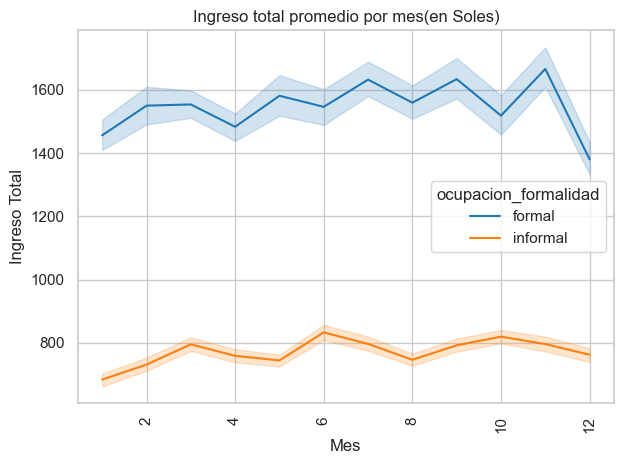

In [160]:
# Gráfico lineal
sns.lineplot(data=df_sin_outliers, x='mes', y='ingreso_total', hue='ocupacion_formalidad')

#Título y ejes
plt.title('Ingreso total promedio por mes(en Soles)')
plt.xlabel('Mes')
plt.ylabel('Ingreso Total')
plt.xticks(rotation = 90)

#Ajustamos el gráfico y lo mostramos
plt.tight_layout()
plt.show()

El gráfico refleja claramente las diferencias en los ingresos entre trabajadores formales e informales a lo largo de los meses del año. La ocupación formal tiene un ingreso promedio más alto y más fluctuante, mientras que los ingresos informales se mantienen bajos y constantes. Esto refuerza la idea de que los trabajadores informales suelen estar en una situación económica más vulnerable, con ingresos más bajos y menos variabilidad, lo que podría reflejar la falta de beneficios adicionales o estabilidad laboral que caracterizan a los trabajos formales.

* Porcentaje de pobreza según 'zonas' : rural y urbano

Porcentaje Pobreza:
👉zonas
rural     38.0
urbano    17.0
dtype: float64


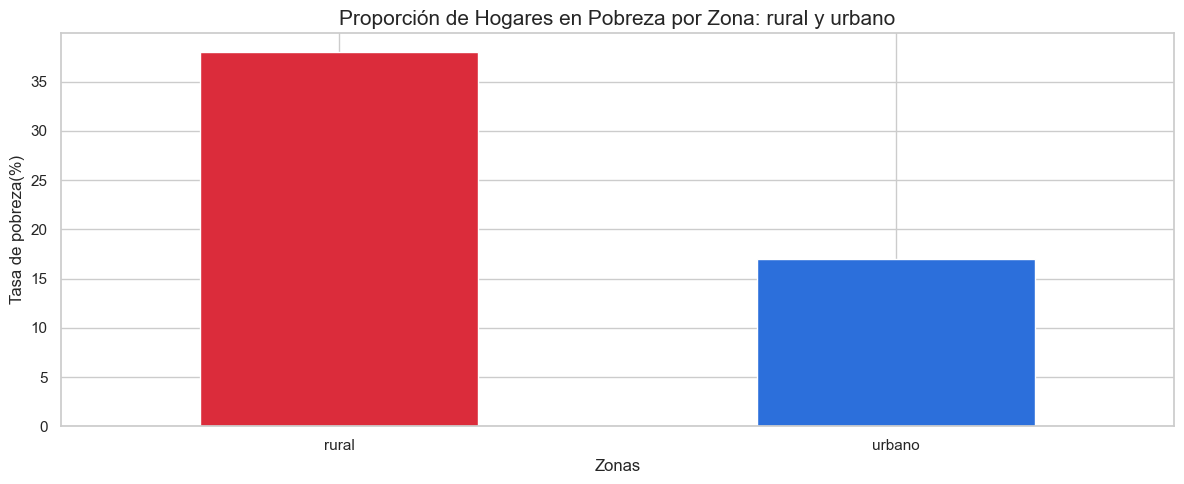

In [161]:
#filtramos hogares por debajo de la línea de pobreza
hogares_pobreza = df_sin_outliers[df_sin_outliers['es_pobre'] == 1]

#proporción de hogares en pobreza por zona
proporcion_pobreza_zonas = (hogares_pobreza.groupby('zonas').size() / df.groupby('zonas').size() * 100).round(0)

# Mostrar resultados
print(f"Porcentaje Pobreza:\n👉{proporcion_pobreza_zonas}")

#Gráfico de barras para visualizar la proporción de hogares en pobreza por zona
plt.figure(figsize=(12,5))
order_color = ['#DB2C3B', '#2C6FDB']
proporcion_pobreza_zonas.plot(kind='bar', color = order_color)
plt.title('Proporción de Hogares en Pobreza por Zona: rural y urbano', fontsize = 15)
plt.xlabel('Zonas', fontsize = 12)
plt.ylabel('Tasa de pobreza(%)', fontsize = 12)

#etiquetas del eje x horizontal
plt.xticks(rotation = 0)
#mostrar gráfico
plt.tight_layout()
plt.show()

Las variables con mayor correlación más fuerte son:

* ingreso_total y es_pobre: (-0.56) negativa fuerte
* es_formal y es_pobre: (0.26) positiva moderada.
* ingreso_total y es_formal: (-0.39) negativa moderada.

##### Resumen: Análisis exploratorio de datos (EDA)

* Variables numéricas:
    * ingreso_total muestra una distribución sesgada positivamente, con la mayoría de los * ingresos concentrados por debajo de 2,000 soles.
    * Se identificó diferencias significativas en ingresos entre zonas urbanas y rurales.

* Variables categóricas:
    * Las visualizaciones muestran cómo las categorías ocupacionales y la formalidad laboral afectan los ingresos y la pobreza.

* Correlaciones clave:

 * Ingreso y pobreza: Relación negativa fuerte (-0.56).
 * Formalidad y pobreza: Relación positiva moderada (0.26).
 * Ingreso y formalidad: Relación negativa moderada (-0.39).

#### 5. Métodos Estadísticos avanzados: 

##### 5.1. Regresión Logística: Relación entre ingreso_total, es_formal y 'es_pobre'

¿Por qué regresión logística?

* Dado que tenemos una variable binaria 'es_pobre', es ideal para un análisis de clasificación
* Este método permitirá evaluar como factores como 'ingreso_total', 'es_formal', 'zonas' influyen en la probabilidad de que un hogar sea clasificado como pobre.

Resultado esperado:
* Coeficientes que muestren el impacto de cada variable en la probabilidad de pobreza.
* Interpretación: por ejemplo, un coeficiente negativo para ingreso_total indicará que mayores ingresos reducen la probabilidad de ser pobre.

In [162]:
#Importar las librerías necesarias
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import f_oneway

In [163]:
# 1. Regresión Logística: Relación entre 'ingreso_total', 'es_formal' y 'es_pobre'
x = df_sin_outliers[['ingreso_total', 'es_formal']]
y = df_sin_outliers['es_pobre']

model = LogisticRegression(max_iter = 1000, random_state = 42)
model.fit(x,y)

# Resultados del modelo
coeficientes = pd.DataFrame({
    'variable': x.columns,
    'coeficiente': model.coef_[0]
})

print(coeficientes)

        variable  coeficiente
0  ingreso_total    -0.027060
1      es_formal    -1.082641


##### Resultados:

* Coeficiente de ingreso_total (-0.027060):

    * El coeficiente negativo indica que a medida que el ingreso total aumenta, la probabilidad de ser clasificado como pobre disminuye.
    * Aunque el impacto directo es pequeño (por cada unidad de ingreso adicional, la probabilidad de pobreza decrece en un 2.7% aproximadamente), este resultado es consistente con la hipótesis de que mayores ingresos reducen la pobreza.

* Coeficiente de es_formal (-1.082641):

    * El coeficiente negativo y de mayor magnitud muestra que estar en un trabajo formal reduce significativamente la probabilidad de ser clasificado como pobre.
    * Este hallazgo refuerza la idea de que la formalidad laboral es un factor protector frente a la pobreza.

* Interpretación:

    * El ingreso y la formalidad laboral tienen un impacto significativo y negativo en la pobreza.
    * Esto sugiere que las políticas públicas que promuevan el aumento de ingresos y la formalización laboral podrían ser efectivas para reducir la pobreza en Perú.

##### 5.2. Índice de Gini y percentiles

¿Por qué Índice de Gini?

* Los datos de ingreso_total ya muestran desigualdad significativa. El índice de Gini y las proporciones entre percentiles (como P90/P10) son métricas estándar para medir desigualdad económica.
* Estos métodos complementan tu análisis al proporcionar una medida concreta de la distribución del ingreso.

Resultado esperado:
* Valores que cuantifiquen la desigualdad económica en tu muestra. Por ejemplo:
        Índice de Gini cercano a 0 indica igualdad perfecta.
        Índice de Gini cercano a 1 indica desigualdad máxima.

In [164]:
# 2. Índice de Gini y Percentiles
def gini(array):
    array = np.sort(array)
    cum_income = np.cumsum(array) / array.sum()
    n = len(array)
    gini_index = 1 - (2 / n) * np.sum(cum_income) + (1 / n)
    return gini_index

gini_coefficient = (gini(df_sin_outliers['ingreso_total'])).round(2)
p90 = df_sin_outliers['ingreso_total'].quantile(0.9)
p10 = df_sin_outliers['ingreso_total'].quantile(0.1)
p90_p10_ratio = p90 / p10

print(f'Índice de Gini: {gini_coefficient}, p90-p10: {p90_p10_ratio}')

Índice de Gini: 0.45, p90-p10: 12.0


##### Resultados:

* Índice de Gini: 0.45:
    * Este valor indica un nivel moderado-alto de desigualdad en la distribución de ingresos en la muestra.
    * En el contexto internacional, un Gini superior a 0.4 generalmente se asocia con una alta desigualdad.

* Interpretación:
    * Existe una brecha significativa entre los ingresos de los hogares con mayores recursos y aquellos en los niveles más bajos.
    * Este nivel de desigualdad podría estar contribuyendo a mantener altos índices de pobreza en ciertas regiones, especialmente en áreas rurales.

* P90/P10 Ratio:

* P90/P10 Ratio: 12.0:
    * Los ingresos del percentil 90 son 12 veces mayores que los del percentil 10.
    * Esto indica una gran disparidad entre los ingresos más altos y más bajos en la población.

* Interpretación:
    * Una brecha de este nivel muestra que los hogares con ingresos más bajos tienen un acceso muy limitado a recursos económicos, en comparación con los hogares en el percentil más alto.
    * Este hallazgo refuerza la idea de que los ingresos están altamente concentrados en un pequeño grupo de la población.

##### 5.3. ANOVA (Análisis de varianza)

¿Por qué Índice de ANOVA?

* Los datos categóricos (zonas, ocupacion_formalidad) son perfectos para analizar cómo el ingreso varía entre grupos.
* Esto permitirá identificar diferencias significativas en los ingresos entre regiones (dominio) o entre ocupaciones formales e informales.

Resultado esperado:
* Identificación de diferencias significativas en ingresos entre grupos (por ejemplo, entre trabajadores formales e informales).
* Visualización clara de estas diferencias mediante boxplots.

##### Resultados:

* F-Statistic: 7597.9497
* p-Value: 0.0

* Interpretación:
    * El valor de p-Value = 0.0 indica que las diferencias de ingreso entre zonas urbanas y rurales son estadísticamente significativas.
    * Los ingresos en las zonas urbanas son consistentemente más altos que en las rurales, lo que refleja disparidades económicas significativas entre estas áreas.
    * Este resultado es consistente con la tendencia observada en países en desarrollo, donde las áreas urbanas suelen ofrecer mejores oportunidades económicas.

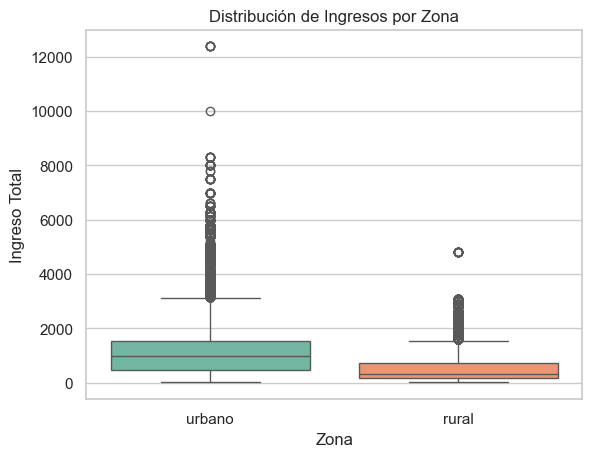

F-Statistic: 7597.949737154366, p-Value: 0.0


In [165]:
# 5.3. ANOVA: Comparación de ingresos entre zonas
urbano = df_sin_outliers[df_sin_outliers['zonas'] == 'urbano']['ingreso_total']
rural = df_sin_outliers[df_sin_outliers['zonas'] == 'rural']['ingreso_total']
f_stat, p_val = f_oneway(urbano, rural)

# Visualización de ingresos por zona
sns.boxplot(data=df_sin_outliers, x='zonas', y='ingreso_total', palette="Set2")
plt.title('Distribución de Ingresos por Zona')
plt.xlabel('Zona')
plt.ylabel('Ingreso Total')
plt.show()

print(f'F-Statistic: {f_stat}, p-Value: {p_val}')

In [166]:
## Mostrar resultados
analysis_results = {
    "Regresión Logística (Coeficientes)": coeficientes,
    "Índice de Gini": gini_coefficient,
    "P90/P10 Ratio": p90_p10_ratio,
    "ANOVA F-Statistic": f_stat,
    "ANOVA p-Value": p_val
}

print(analysis_results)

{'Regresión Logística (Coeficientes)':         variable  coeficiente
0  ingreso_total    -0.027060
1      es_formal    -1.082641, 'Índice de Gini': 0.45, 'P90/P10 Ratio': 12.0, 'ANOVA F-Statistic': 7597.949737154366, 'ANOVA p-Value': 0.0}


#### Resumen: 5. Métodos estadísticos avanzados

##### Regresión Logística:

* Evalúa cómo ingreso_total y es_formal influyen en la probabilidad de pobreza (es_pobre).
    * Coeficientes muestran que:
        * Aumentar ingresos reduce la probabilidad de pobreza (-0.027).
        * La formalidad laboral es un factor protector (-1.083).

##### Índice de Gini y percentiles:

* Gini: 0.45, indicando desigualdad económica moderada-alta.
* P90/P10 Ratio: 12, reflejando una gran disparidad entre ingresos altos y bajos.
* ANOVA:
    * Identifica diferencias significativas entre ingresos en zonas urbanas y rurales (p-value = 0.0).

## 6. Resultados principales

* Impacto de los ingresos:

    * Incrementar los ingresos tiene un efecto directo en la reducción de la pobreza.
    * 38% de los hogares rurales y 17% de los urbanos son pobres.

* Formalidad laboral:

    * Estar en un trabajo formal reduce significativamente la probabilidad de pobreza, aunque no es suficiente para erradicarla.

* Desigualdad económica:

    * La desigualdad afecta principalmente a los hogares en zonas rurales, que tienen ingresos consistentemente más bajos.

##### 7.Recomendaciones

* 7.1. Promover la formalización laboral:

    * Simplificar los procesos para el registro de trabajadores en la seguridad social.
    * Incentivar la formalización en sectores clave en áreas rurales.

* Ejemplo: "MiPrimerEmpleo" en Colombia

    * Descripción: Este programa otorgó incentivos fiscales a empresas que contrataran jóvenes como su primer empleo formal. La medida redujo las tasas de informalidad entre jóvenes recién egresados y mejoró sus ingresos.
    * Impacto: Disminución de la informalidad juvenil y aumento de ingresos promedio en jóvenes de sectores vulnerables.

* 7.2.Reducir la desigualdad:

    * Diseñar programas redistributivos y subsidios directos para los hogares más vulnerables.
    * Incrementar la inversión en educación y capacitación en zonas rurales.

* Ejemplo: "Bolsa Familia" en Brasil

    * Descripción: Un programa de transferencias condicionadas de dinero a hogares en situación de pobreza. Las familias recibían apoyo económico si cumplían condiciones como la asistencia escolar y la vacunación de sus hijos.
    * Impacto: Redujo significativamente la pobreza extrema en zonas rurales y urbanas, y mejoró indicadores de salud y educación.

* 7.3.Fomentar el desarrollo económico en áreas rurales:

    * Implementar proyectos de infraestructura y conectividad para mejorar el acceso al mercado.
    * Estimular la inversión privada en regiones con menor desarrollo.

* Ejemplo: "Infraestructura rural en Bangladesh"

    * Descripción: Inversión en infraestructura como caminos rurales y conectividad eléctrica en comunidades aisladas, mejorando el acceso al mercado para pequeños agricultores.
    * Impacto: Incremento del 20% en ingresos rurales y reducción de la pobreza debido a mejores oportunidades económicas.

* 7.4. Acceso a servicios financieros y créditos:

* Ejemplo: "Microcréditos Grameen Bank" en Bangladesh

    * Descripción: Grameen Bank introdujo microcréditos dirigidos a comunidades rurales para fomentar el emprendimiento, especialmente en mujeres.
    * Impacto: Incremento en los ingresos familiares y reducción de la pobreza extrema en comunidades rurales.

* 7.5. Educación y capacitación laboral:

* Ejemplo: "Skilling India" en India

    * Descripción: Iniciativa nacional para capacitar a millones de personas con habilidades técnicas y empresariales, enfocándose en áreas rurales.
    * Impacto: Mejoras en empleabilidad rural y mayor formalización de los trabajadores en sectores clave.


In [167]:
#Guardamos el nuevo conjunto de datos

df_sin_outliers.to_csv('dataPobrezaPeru2022.csv',index=False)